## Loading Dataset

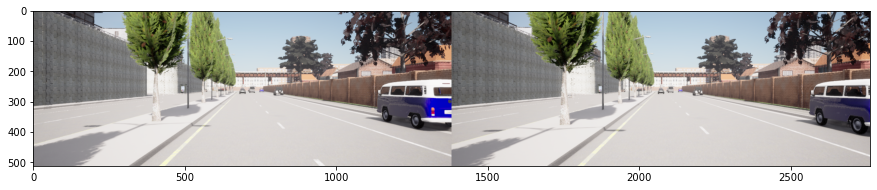

In [32]:
%matplotlib inline

import numpy as np
from numpy.matlib import repmat
import glob
import matplotlib.pyplot as plt
import json
from skimage import io
import cv2


def read_depth(depth_file):
    depth = io.imread(depth_file)
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    return depth

def plot_pair(img1_path, img2_path):
    plt.figure(figsize=(15,5))
    img0 = plt.imread(img1_path)
    img1 = plt.imread(img2_path)
    plt.imshow(np.hstack((img0, img1)))
    plt.show()

def print_matrix(matrix):
    matrix = np.array(matrix)
    for i in range(matrix.shape[0]):
        print(matrix[i,:])
    print("\n")

data_root = "/storage/remote/atcremers40/motion_seg/datasets/Carla_tmp/"
images = sorted(list(glob.glob(os.path.join(data_root, f"images/**/*.png"))))
transformations = sorted(list(glob.glob(os.path.join(data_root, f"transformations/**/*.json"))))
depths = sorted(list(glob.glob(os.path.join(data_root, f"depth/**/*.png"))))

first_image_idx = 196
offset = 1

plot_pair(images[first_image_idx], images[first_image_idx+offset])

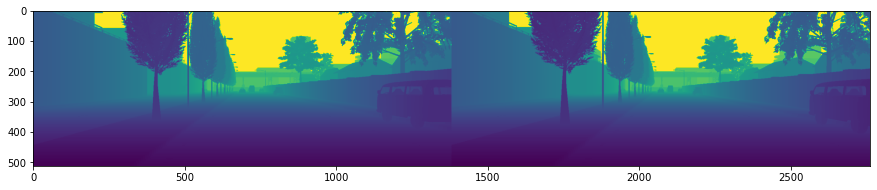

/storage/remote/atcremers40/motion_seg/datasets/Carla_tmp/depth/0000/0196.png
(512, 1382)


In [33]:
depth0 = plt.imread(depths[first_image_idx])
depth1 = plt.imread(depths[first_image_idx+offset])
plot_pair(depths[first_image_idx], depths[first_image_idx+offset])
print(depths[first_image_idx])
print(depth0.shape)
# plt.figure(figsize=(30,15))
# plt.imshow(depth0)

In [34]:
trs_list = []
for i in range(len(transformations)):
    with open(transformations[i], "r") as f:
        trs_list.extend(json.load(f)["transforms"])

trs = np.array(trs_list[first_image_idx + offset])
for i in range(offset-1,0, -1):
    trs = np.array(trs_list[first_image_idx + i]) @ trs
    
print(trs)

[[ 1.00000000e+00  2.37603904e-06  2.53111527e-12  1.42398701e+00]
 [-2.37603904e-06  1.00000000e+00  4.59542626e-12 -2.00345679e-06]
 [-2.53110435e-12 -4.59543227e-12  1.00000000e+00 -2.71604167e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## General Funcs

In [35]:
def get_intrinsics(fov, image_size_x, image_size_y):
    f = image_size_x/(2.0 * np.tan(fov * np.pi /360))
    Cx = image_size_x / 2.0
    Cy = image_size_y / 2.0
    return np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]])

def reproject(u, depth, image_size_x, image_size_y, K=None):
    '''
    get [u,v] pixel coordinates and convert to homogeneous
    get instrinsics
    multiply inverse K with the homogeneous points and scale depth
    '''
    # unpacking (christmas presents)
    u_coords, v_coords = u[:,0], u[:,1]

    # get homogeneous coords
    p = np.array([u_coords, v_coords, np.ones_like(u_coords)])

    # get K
    if K is None:
        K = get_intrinsics(72/(2*np.pi), image_size_x, image_size_y)

    # get 3D points
    p3d = np.dot(np.linalg.inv(K), p) * depth.reshape((-1)) * 1000
    return p3d.T

def rotx(angle):
    return np.array([
        [1,0,0,0],
        [0,np.cos((angle*np.pi)/180), -np.sin((angle*np.pi)/180), 0],
        [0,np.sin((angle*np.pi)/180), np.cos((angle*np.pi)/180), 0],
        [0,0,0,1]
    ])

def roty(angle):
    return np.array([
        [np.cos((angle*np.pi)/180),0, np.sin((angle*np.pi)/180),0],
        [0,1,0,0],
        [-np.sin((angle*np.pi)/180),0, np.cos((angle*np.pi)/180),0],
        [0,0,0,1]
    ])

def rotz(angle):
    return np.array([
        [np.cos((angle*np.pi)/180), -np.sin((angle*np.pi)/180),0,0],
        [np.sin((angle*np.pi)/180), np.cos((angle*np.pi)/180),0,0],
        [0,0,1,0],
        [0,0,0,1]
    ])

def build_se3(rotation, translation):
    se3 = np.hstack((rotation, np.array([translation]).T))
    se3 = np.vstack((se3,np.array([0,0,0,1])))
    return se3

def inverse_se3(se3_mat):
    R_T = se3_mat[:3, :3].T
    new_t = -R_T.dot(se3_mat[:3,-1])

    return build_se3(R_T, new_t)

def transform_pointcloud(pc, trs):
    # somehow ensure correct direction of trs
    pc = np.hstack([pc, np.ones((pc.shape[0],1))])
    pc_trs = trs@pc.T
    return pc_trs[:3,:].T

def project(p3d, image_size_x, image_size_y):
    '''
    gets intrinsics, projects points into the image plane
    and normalises the pixels
    '''   
    K = get_intrinsics(72/(2*np.pi), image_size_x, image_size_y)
    unnormalised_pixel_coords = np.dot(K, p3d.T).T
    pixel_coords = unnormalised_pixel_coords/(unnormalised_pixel_coords[:,2].reshape((-1,1)))
    return pixel_coords[:,:2]

def get_flow(depth0, image_size_x, image_size_y, trs, K=None):
    # 2d pixel coordinates
    pixel_length = image_size_x * image_size_y
    u_coords = repmat(np.r_[image_size_x-1:-1:-1],
                        image_size_y, 1).reshape(pixel_length)
    v_coords = repmat(np.c_[image_size_y-1:-1:-1],
                        1, image_size_x).reshape(pixel_length)

    u_coords = np.flip(u_coords)
    v_coords = np.flip(v_coords)
    u = np.array([u_coords, v_coords]).T # u horizontal (x), v vertical (-y)

    pc0 = reproject(u, depth0, image_size_x, image_size_y, K)

    # find transformation
    trs = inverse_se3(trs)

    # (CX_T_1 @ 1_T_Sensor1)^-1 @ C2_trs_C1 @ (CX_T_1 @ 1_T_Sensor2)
    CX_T_Sensor = (roty(90) @ rotz(90))
    CX_T_Sensor_inv = inverse_se3(roty(90) @ rotz(90))
    trs = CX_T_Sensor_inv @ trs @ CX_T_Sensor

    pc0_trs = transform_pointcloud(pc0, trs)
    u_dash = project(pc0_trs, image_size_x, image_size_y)

    flow = u_dash - u
    flow = flow.reshape(image_size_y, image_size_x, 2)

    return flow
  
opt_flow = get_flow(depth0, 1382, 512, trs)

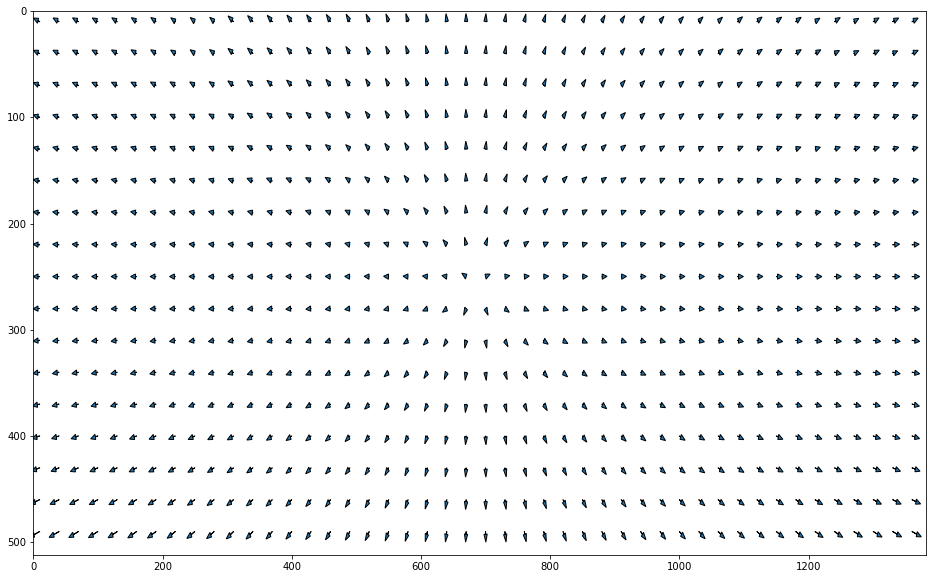

In [36]:
#Visualization of flow vectors 
fig = plt.figure(figsize = (16,10))
# plt.xlim(0,512)
plt.xlim(0,1382)
plt.ylim(0,512)
plt.gca().invert_yaxis()

disc_step = 30
of_offset = 10

for i in range(of_offset, opt_flow.shape[0]-of_offset, disc_step):
    for j in range(of_offset,opt_flow.shape[1]-of_offset, disc_step):
        plt.arrow(j,i,opt_flow[i,j,0], opt_flow[i,j,1], head_width=5)
fig.show()

## Visualise Flow Using CV2

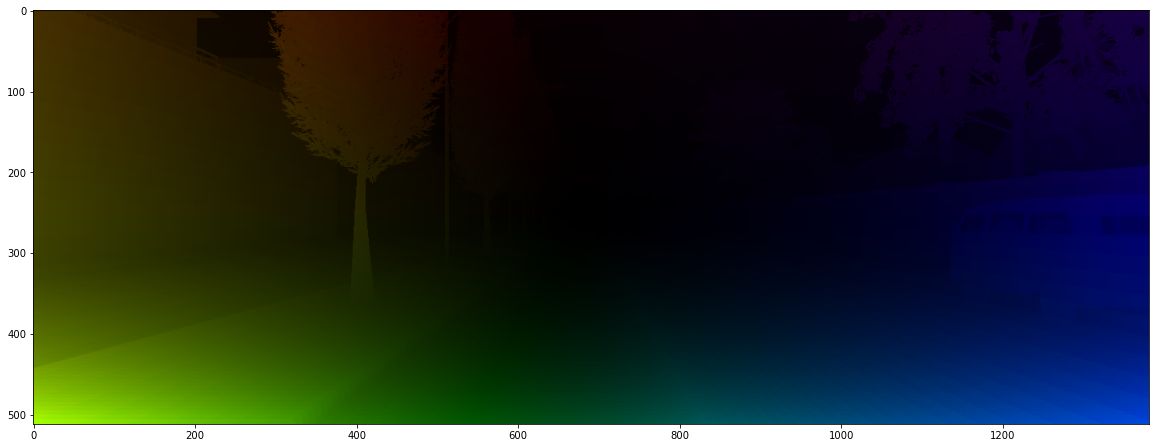

In [37]:
# Taken from: https://learnopencv.com/optical-flow-in-opencv/

# create HSV & make Value a constant
hsv = np.zeros((512,1382,3))
hsv[:,:,1] = 255

# Encoding: convert the algorithm's output into Polar coordinate
opt_flow_reshaped = opt_flow.reshape((512,1382,-1))
mag, ang = cv2.cartToPolar(opt_flow_reshaped[...,0], opt_flow_reshaped[...,1])
# Use Hue and Value to encode the Optical Flow
hsv[:,:, 0] = ang * 180 / np.pi / 2
hsv[:,:, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
# Convert HSV image into BGR for demo
bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
plt.figure(figsize=(20,10))
plt.imshow(bgr)

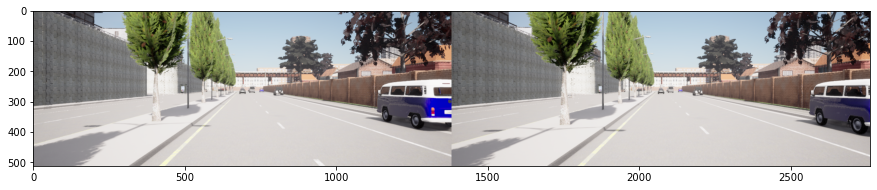

In [38]:
plot_pair(images[first_image_idx], images[first_image_idx+offset])

## Loading Pickled as Test

In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
path = "/storage/remote/atcremers40/motion_seg/datasets/Carla_tmp/static_flow/0000/static_flow.pkl"
flow = np.load(path)

In [40]:
def vis_flow(flow):
    # create HSV & make Value a constant
    hsv = np.zeros((512,1382,3))
    hsv[:,:,1] = 255

    # Encoding: convert the algorithm's output into Polar coordinate
    flow_reshaped = flow.reshape((512,1382,-1))
    mag, ang = cv2.cartToPolar(flow_reshaped[...,0], flow_reshaped[...,1])
    # Use Hue and Value to encode the Optical Flow
    hsv[:,:, 0] = ang * 180 / np.pi / 2
    hsv[:,:, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV image into BGR for demo
    bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    plt.figure(figsize=(20,10))
    plt.imshow(bgr)

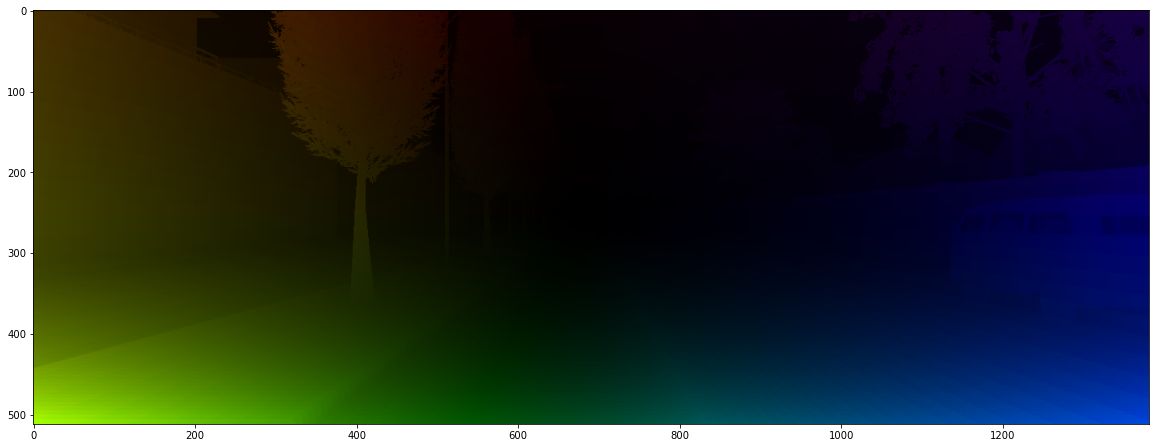

In [43]:
vis_flow(flow[196])